# <tt>synphot</tt>: Simulating spectroscopy

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
<li>Query data directly from other websites using `astropy.coordinates.Skycoord`, `astroquery.Gaia`, `astropy.io`, and `astropy.utils`</li>
<li>Construct a source spectrum using `synphot.SourceSpectrum`</li>
<li>Model the effect of the quantum efficiency on the source spectrum with `synphot.SpectralElement`</li>
<li>Perform synthetic spectroscopy by binning the wavelengths according to R with `synphot.Observation`
<li>Combine all of these effects into a simulated observation with `synphot.Observation`</li>
<li>Compute the expected count rate from this observation with `synphot`'s `countrate()` function
</ul>

## Keywords
synphot, synthetic spectroscopy, astropy, astroquery, astronomy

## Summary
In this tutorial we will:
<ol>
<li><a href="#query_properties">Query the properties of our target star</a> (HAT-P-11 to start)</li>
<li><a href="#phoenix">Download model spectra from PHOENIX</a></li>
<li><a href="#source_spectrum">Construct a source spectrum</a></li>
<li><a href="#spectroscopy">Simulate an observation with a spectrometer</a></li>
<li><a href="#qe">Model the effect of the quantum efficiency</a></li>
<li><a href="#observation">Combine all of the effects and "observe"</a></li>
<li><a href="#counts">Compute the count rate and total counts</a></li>
<li><a href="#trappist1">Look at another example, this time with TRAPPIST-1</a></li>
</ol>

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from synphot import units

<a id='query_properties'></a>
## 1. Query the properties of HAT-P-11

First we get the star's parameters using astroquery's <a href="https://astroquery.readthedocs.io/en/latest/gaia/gaia.html">Gaia query</a> and astropy's <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html">SkyCoord</a>: 

In [17]:
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

ID = 'HAT-P-11'

coord = SkyCoord.from_name(ID)
width = u.Quantity(1, u.arcmin)  # width / height of search
height = u.Quantity(1, u.arcmin)
search_results = Gaia.query_object_async(coordinate=coord, width=width, height=height)

# the queried star will be the one nearest to the given coordinates
search_results.add_index('dist', unique=True)
hatp11_info = search_results.loc['dist', min(search_results['dist'])]

# now get the parameters
stellar_radius = hatp11_info['radius_val'] * u.R_sun
# divide 1 AU by parallax (arcseconds) to get distance in parsecs.
# parallax is given in milliarcseconds, so multiply by 1000: 
distance = (1 / (hatp11_info['parallax']) * 1000) * u.pc
T_eff = hatp11_info['teff_val']

Query finished.


<a id="phoenix"></a>
## 2. Download a model spectrum for HAT-P-11 from <a href="http://phoenix.astro.physik.uni-goettingen.de/">PHOENIX</a>:

In [18]:
from astropy.io import fits

T_eff = round(T_eff, -2)  # round to nearest 100 K

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=int(T_eff), log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

<a id="source_spectrum"></a>
## 3. Construct a `synphot` <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">source spectrum object</a> from the above arrays:

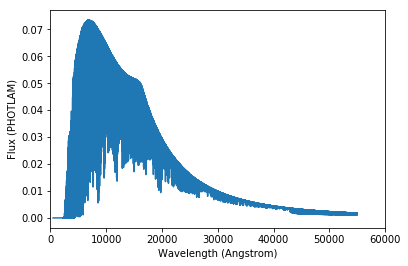

In [19]:
from synphot.spectrum import SourceSpectrum
from synphot.models import Empirical1D

photlam_hatp11 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
photlam_hatp11 = photlam_hatp11 * float(stellar_radius / distance) ** 2 / np.pi

photlam_hatp11.plot(flux_unit='PHOTLAM', left=0, right=60000)

(for other methods of constructing source spectra with `synphot`, see the first bulleted list <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">here</a>) 

<a id="spectroscopy"></a>
## 4. Simulate an observation with a spectrometer

We will model the spectrometer after the instrument on the planned <a href="https://en.wikipedia.org/wiki/CHEOPS">CHEOPS satellite</a>, setting a spectral resolution R = 1000.

In [20]:
aperture_radius = 32 / 2 * u.cm  # radius of 32 cm CHEOPS satellite
aperture_area = np.pi * aperture_radius ** 2
R = 1000  # spectral resolution lambda

The CHEOPS spectrometer will observe in wavelengths ranging from 0.33 - 1.1 microns:

In [46]:
# set a constant delta_wavelength defined by R and the wavelength in the center of the range
wl_in_center = ((1.1 - 0.33) / 2 + 0.33)
delta_wavelength = wl_in_center / R
# get the spectral wavelength array. This will be the observational binset
spec_wavelengths = np.arange(0.33, 1.1 + delta_wavelength,
                        delta_wavelength) * u.micron
# convert to angstroms
spec_wavelengths = spec_wavelengths.to(u.angstrom)

To see what the binned spectrum looks like before hitting the CCD, create a bandpass object from a box uniform bandpass of amplitude = 1, which is equivalent to observing through no filter:

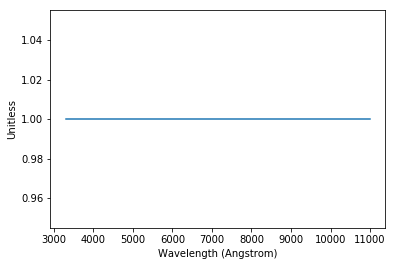

In [60]:
from synphot import SpectralElement
from astropy.modeling.models import Const1D

uniform_bp = SpectralElement(Const1D, amplitude=1)
uniform_bp.plot([3300, 11000])

Now we simulate spectroscopy by setting the `binset` of the Observation object equal to the wavelength bins defined by R and the waverange of the instrument:

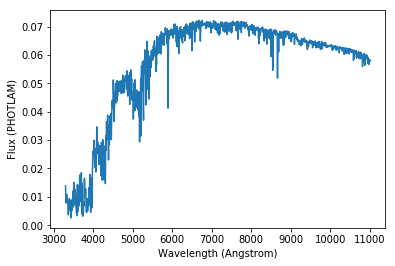

In [61]:
from synphot.observation import Observation

observation_preccd = Observation(photlam_hatp11, uniform_bp, binset=spec_wavelengths, force='extrap')
observation_preccd.plot()

Plot the binned photometry (aka spectroscopy) on top of the source spectrum for comparison:

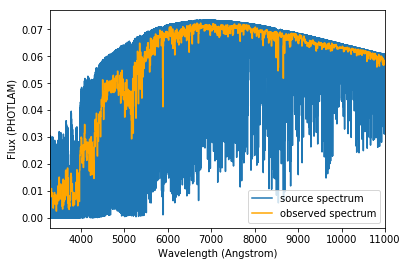

In [75]:
plt.plot(photlam_hatp11.waveset, photlam_hatp11(photlam_hatp11.waveset), label='source spectrum')
plt.step(spec_wavelengths, observation_preccd.binflux, color='orange', label='observed spectrum')
plt.xlim(3300, 11000)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (PHOTLAM)')
plt.legend()

<a id="qe"></a>
## 5. Model the effect of the CCD's quantum efficiency on the spectrum

For this we use the values in the table found in section 3.5 on <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/#3p5">this page</a>.

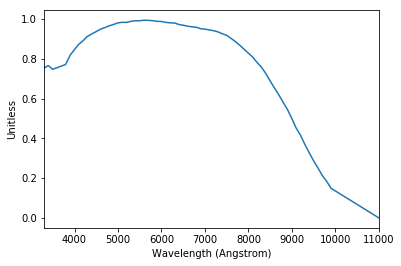

In [63]:
quantum_efficiency = SpectralElement.from_file('ccd_QE.csv', wave_unit="nm")
quantum_efficiency = quantum_efficiency / 100  # convert percentages to decimals

quantum_efficiency.plot(left=3300, right=11000)

<a id="observation"></a>
## 6. Combine the effects and "observe"

Finally, we convolve the source spectrum with the CCD efficiency and bin according to the spectral resolution using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html">Observation</a>:

(3300, 11000)

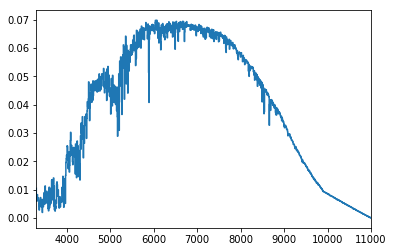

In [74]:
from synphot.observation import Observation

observation = Observation(photlam_hatp11, quantum_efficiency, binset=spec_wavelengths)
plt.step(spec_wavelengths, observation.binflux)
plt.xlim(3300, 11000)
# observation.plot(left=3300, right=11000)

<a id="counts"></a>
## 7. Compute the count rate and total counts

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate">countrate()</a> method on the observation object: 

In [65]:
countrate = observation.countrate(area=aperture_area)

How many counts can we expect in a 10s exposure?

In [66]:
counts_hatp11 = countrate * 10 * u.s

print("HAT-P-11 counts in 10 s exposure:")
print(int(counts_hatp11.value), "cts")

HAT-P-11 counts in 10 s exposure:
2395564 cts


<a id="trappist1"></a>
## 8. Another example, this time with <a href="https://en.wikipedia.org/wiki/TRAPPIST-1">TRAPPIST-1</a>

(using the same instrument and telescope)

In [67]:
T_eff = 2600  # approx temperature of trappist-1 [K], Gillon 2017

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=T_eff, log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

Unfortunately Gaia does not have all the parameters we need for TRAPPIST-1, so we use the values cited in <a href="https://arxiv.org/pdf/1703.01424.pdf">Gillon 2017</a>:

In [68]:
photlam_trappist1 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
stellar_radius = 0.117 * u.R_sun  # radius of trappist-1 in solar units
distance = 12.1 * u.pc  # distance to trappist-1 in parsecs
photlam_trappist1 = photlam_trappist1 * float(stellar_radius / distance) ** 2 / np.pi

Bin the flux according to the spectral resolution:

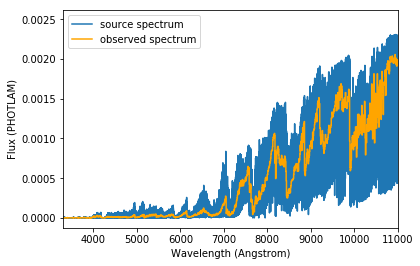

In [76]:
observation_preccd = Observation(photlam_trappist1, uniform_bp, binset=spec_wavelengths, force='extrap')

plt.plot(photlam_trappist1.waveset, photlam_trappist1(photlam_trappist1.waveset), label='source spectrum')
plt.step(spec_wavelengths, observation_preccd.binflux, color='orange', label='observed spectrum')
plt.xlim(3300, 11000)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (PHOTLAM)')
plt.legend()

After hitting the CCD we get:

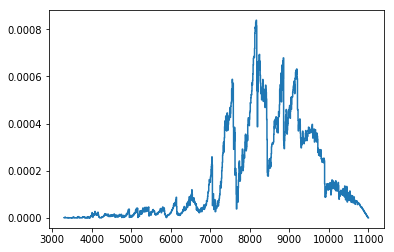

In [79]:
observation = Observation(photlam_trappist1, quantum_efficiency, binset=spec_wavelengths)
plt.step(spec_wavelengths, observation.binflux)

In [78]:
countrate = observation.countrate(area=aperture_area)
counts_trappist1 = countrate * 10 * u.s

print("TRAPPIST-1 counts, 10 s exposure:")
print(int(counts_trappist1.value), "cts")

TRAPPIST-1 counts, 10 s exposure:
10142 cts
